# Import related Modules

In [85]:
# To plot pretty figures
import datetime as dt
import matplotlib as mpl

# General libraries needed
import time # use to measure how long PCA takes in comparison to LLE
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm

# TensorFlow requirements
import tensorflow as tf
from tensorflow import keras

# Sklearn requirements
from sklearn.linear_model import Perceptron

# Special graphing modules used
from pandas.plotting import scatter_matrix

# scikit learn modules
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.linear_model import SGDRegressor, LinearRegression, Ridge
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from sklearn.metrics import precision_score, recall_score, precision_recall_curve, roc_curve, roc_auc_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
# Feature Reduction and Visulization
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Binary classifier only?
from sklearn.tree import DecisionTreeClassifier

#Random forest
from sklearn.ensemble import RandomForestClassifier

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder, PowerTransformer, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

Function Definition

In [62]:
#function that shows a learning curve for any model that has predict or fit methods
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator,X,y,ylim=None,cv=None,n_jobs=None,train_sizes=np.linspace(0.1, 1.0, 20),scoring = 'neg_root_mean_squared_error'):
    
    _, axes = plt.subplots(1, 1, figsize=(10, 5))    
    axes.set_title('Learning Curve')
    if ylim is not None:
        axes.set_ylim(*ylim)
    axes.set_xlabel("Training examples")
    axes.set_ylabel(scoring)

    train_sizes, train_scores, test_scores= learning_curve(estimator,X,y,cv=cv,n_jobs=n_jobs,train_sizes=train_sizes,scoring = scoring)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Plot learning curve
    axes.grid()
    axes.fill_between(train_sizes,train_scores_mean - train_scores_std,train_scores_mean + train_scores_std,alpha=0.1,color="r")
    axes.fill_between(train_sizes,test_scores_mean - test_scores_std,test_scores_mean + test_scores_std,alpha=0.1,color="g")
    axes.plot(train_sizes, train_scores_mean, "o-", color="r", label="Training score")
    axes.plot(train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score")
    axes.legend(loc="best")
    plt.show()
    
    return

#code to prevent warnings that can occur as a result of this function
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

In [63]:
#function provided that plots the learning curve for neural networks
def nn_plot_learning_curve( history ):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    ymin, ymax = [], []
    for x in history.history.keys():
        ymax.append( max(history.history[x]))
        ymin.append( min(history.history[x]))
    plt.gca().set_ylim(min(ymin)*.95, max(ymax)*1.05)
    plt.xlabel("EPOCHS")
    plt.show()

Source Data

In [64]:
from google.colab import files
uploaded = files.upload()

Saving heart_2020_cleaned.csv to heart_2020_cleaned (1).csv


In [65]:
df = pd.read_csv('heart_2020_cleaned.csv')
df.head()

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,No,16.60,Yes,No,No,3,30,No,Female,55-59,White,Yes,Yes,Very good,5,Yes,No,Yes
1,No,20.34,No,No,Yes,0,0,No,Female,80 or older,White,No,Yes,Very good,7,No,No,No
2,No,26.58,Yes,No,No,20,30,No,Male,65-69,White,Yes,Yes,Fair,8,Yes,No,No
3,No,24.21,No,No,No,0,0,No,Female,75-79,White,No,No,Good,6,No,No,Yes
4,No,23.71,No,No,No,28,0,Yes,Female,40-44,White,No,Yes,Very good,8,No,No,No


Prepare the dataset

In [66]:
df['HeartDisease'] = df['HeartDisease'].apply(lambda x:1 if x == "Yes" else 0);
df['Smoking'] = df['Smoking'].apply(lambda x:1 if x == "Yes" else 0);
df['AlcoholDrinking'] = df['AlcoholDrinking'].apply(lambda x:1 if x == "Yes" else 0);
df['Stroke'] = df['Stroke'].apply(lambda x:1 if x == "Yes" else 0);
df['DiffWalking'] = df['DiffWalking'].apply(lambda x:1 if x == "Yes" else 0);
df['Sex'] = df['Sex'].apply(lambda x:1 if x == "Male" else 0);
df['Diabetic'] = df['Diabetic'].apply(lambda x:1 if x == "Yes" else 0);
def helper(x):
  if x == 'Yes':
    return 2
  if x == 'No':
    return 1
  return 0

df['PhysicalActivity'] = df['PhysicalActivity'].apply(helper); # 加一个 no, borderline diabetes
df['Asthma'] = df['Asthma'].apply(lambda x:1 if x == "Yes" else 0);
df['KidneyDisease'] = df['KidneyDisease'].apply(lambda x:1 if x == "Yes" else 0);
df['SkinCancer'] = df['SkinCancer'].apply(lambda x:1 if x == "Yes" else 0);

Updated version of column encoding

In [67]:
from typing import Dict

def encoding(col: pd.DataFrame) -> Dict[object, int]:
  values = sorted(list(set(col.values)))
  return {values[i]: i for i in range(len(values))}

for col in df.columns:
  if df[col].dtypes == object and col not in ["Race", "AgeCategory", "GenHealth"]:
    map = encoding(df[col])
    df[col] = df[col].apply(lambda x: map[x])

df.head(n=10)

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,0,16.60,1,0,0,3,30,0,0,55-59,White,1,2,Very good,5,1,0,1
1,0,20.34,0,0,1,0,0,0,0,80 or older,White,0,2,Very good,7,0,0,0
2,0,26.58,1,0,0,20,30,0,1,65-69,White,1,2,Fair,8,1,0,0
3,0,24.21,0,0,0,0,0,0,0,75-79,White,0,1,Good,6,0,0,1
4,0,23.71,0,0,0,28,0,1,0,40-44,White,0,2,Very good,8,0,0,0
5,1,28.87,1,0,0,6,0,1,0,75-79,Black,0,1,Fair,12,0,0,0
6,0,21.63,0,0,0,15,0,0,0,70-74,White,0,2,Fair,4,1,0,1
7,0,31.64,1,0,0,5,0,1,0,80 or older,White,1,1,Good,9,1,0,0
8,0,26.45,0,0,0,0,0,0,0,80 or older,White,0,1,Fair,5,0,1,0
9,0,40.69,0,0,0,0,0,1,1,65-69,White,0,2,Good,10,0,0,0


In [68]:
df.describe()

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,Diabetic,PhysicalActivity,SleepTime,Asthma,KidneyDisease,SkinCancer
count,319795.000000,319795.000000,319795.000000,319795.000000,319795.000000,319795.00000,319795.000000,319795.000000,319795.000000,319795.000000,319795.000000,319795.000000,319795.000000,319795.000000,319795.000000
mean,0.085595,28.325399,0.412477,0.068097,0.037740,3.37171,3.898366,0.138870,0.475273,0.127588,1.775362,7.097075,0.134061,0.036833,0.093244
std,0.279766,6.356100,0.492281,0.251912,0.190567,7.95085,7.955235,0.345812,0.499389,0.333631,0.417344,1.436007,0.340718,0.188352,0.290775
min,0.000000,12.020000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,0.000000,24.030000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,2.000000,6.000000,0.000000,0.000000,0.000000
50%,0.000000,27.340000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,2.000000,7.000000,0.000000,0.000000,0.000000
75%,0.000000,31.420000,1.000000,0.000000,0.000000,2.00000,3.000000,0.000000,1.000000,0.000000,2.000000,8.000000,0.000000,0.000000,0.000000
max,1.000000,94.850000,1.000000,1.000000,1.000000,30.00000,30.000000,1.000000,1.000000,1.000000,2.000000,24.000000,1.000000,1.000000,1.000000


In [69]:
df.head()

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,0,16.60,1,0,0,3,30,0,0,55-59,White,1,2,Very good,5,1,0,1
1,0,20.34,0,0,1,0,0,0,0,80 or older,White,0,2,Very good,7,0,0,0
2,0,26.58,1,0,0,20,30,0,1,65-69,White,1,2,Fair,8,1,0,0
3,0,24.21,0,0,0,0,0,0,0,75-79,White,0,1,Good,6,0,0,1
4,0,23.71,0,0,0,28,0,1,0,40-44,White,0,2,Very good,8,0,0,0


In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319795 entries, 0 to 319794
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   HeartDisease      319795 non-null  int64  
 1   BMI               319795 non-null  float64
 2   Smoking           319795 non-null  int64  
 3   AlcoholDrinking   319795 non-null  int64  
 4   Stroke            319795 non-null  int64  
 5   PhysicalHealth    319795 non-null  int64  
 6   MentalHealth      319795 non-null  int64  
 7   DiffWalking       319795 non-null  int64  
 8   Sex               319795 non-null  int64  
 9   AgeCategory       319795 non-null  object 
 10  Race              319795 non-null  object 
 11  Diabetic          319795 non-null  int64  
 12  PhysicalActivity  319795 non-null  int64  
 13  GenHealth         319795 non-null  object 
 14  SleepTime         319795 non-null  int64  
 15  Asthma            319795 non-null  int64  
 16  KidneyDisease     31

In [71]:
df.corr()

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,Diabetic,PhysicalActivity,SleepTime,Asthma,KidneyDisease,SkinCancer
HeartDisease,1.000000,0.051803,0.107764,-0.032080,0.196835,0.170721,0.028591,0.201258,0.070040,0.183072,-0.100030,0.008327,0.041444,0.145197,0.093317
BMI,0.051803,1.000000,0.023118,-0.038816,0.019733,0.109788,0.064131,0.181678,0.026940,0.203494,-0.150616,-0.051822,0.092345,0.050768,-0.033644
Smoking,0.107764,0.023118,1.000000,0.111768,0.061226,0.115352,0.085157,0.120074,0.085052,0.058434,-0.097174,-0.030336,0.024149,0.034920,0.033977
AlcoholDrinking,-0.032080,-0.038816,0.111768,1.000000,-0.019858,-0.017254,0.051282,-0.035328,0.004200,-0.058208,0.017487,-0.005065,-0.002202,-0.028280,-0.005702
Stroke,0.196835,0.019733,0.061226,-0.019858,1.000000,0.137014,0.046467,0.174143,-0.003091,0.108407,-0.079455,0.011900,0.038866,0.091167,0.048116
PhysicalHealth,0.170721,0.109788,0.115352,-0.017254,0.137014,1.000000,0.287987,0.428373,-0.040904,0.158207,-0.232283,-0.061387,0.117907,0.142197,0.041700
MentalHealth,0.028591,0.064131,0.085157,0.051282,0.046467,0.287987,1.000000,0.152235,-0.100058,0.025480,-0.095808,-0.119717,0.114008,0.037281,-0.033412
DiffWalking,0.201258,0.181678,0.120074,-0.035328,0.174143,0.428373,0.152235,1.000000,-0.068860,0.216605,-0.278524,-0.022216,0.103222,0.153064,0.064840
Sex,0.070040,0.026940,0.085052,0.004200,-0.003091,-0.040904,-0.100058,-0.068860,1.000000,0.020718,0.048247,-0.015704,-0.069191,-0.009084,0.013434
Diabetic,0.183072,0.203494,0.058434,-0.058208,0.108407,0.158207,0.025480,0.216605,0.020718,1.000000,-0.140571,0.006658,0.044565,0.154268,0.037663


In [72]:
df.isna().sum()

HeartDisease        0
BMI                 0
Smoking             0
AlcoholDrinking     0
Stroke              0
PhysicalHealth      0
MentalHealth        0
DiffWalking         0
Sex                 0
AgeCategory         0
Race                0
Diabetic            0
PhysicalActivity    0
GenHealth           0
SleepTime           0
Asthma              0
KidneyDisease       0
SkinCancer          0
dtype: int64

In [86]:
# Try update random_state to 35 - raise it up.  Gaming the random state JUST to get better learning curve not ALWAYS best method
X_train_pre, X_test_pre, y_train, y_test = train_test_split(
    df.drop(columns=['HeartDisease']), 
    df.HeartDisease, 
    test_size=0.2, 
    random_state=32 ,
)
X_train_pre.shape,X_test_pre.shape,y_train.shape, y_test.shape 

((255836, 17), (63959, 17), (255836,), (63959,))

In [87]:
#no categorical attributes for this data set (nice to have in case data changes)
cat_attribs = ['Race']
#pass_attribs = ['occupation']   #Treat occupution as a category even though it is numeric.  We will just pass it through so occupation categories remain un-scaled

ord_attribs = ['AgeCategory', 'GenHealth']
age_ord = ['18-24','25-29','30-34','35-39', '40-44', '45-49', '50-54', '55-59', '60-64', '65-69', '70-74', '75-79','80 or older']
health_ord = ['Poor', 'Fair', 'Good', 'Very good', 'Excellent'];

all_cat=cat_attribs+ord_attribs
num_attribs = list( X_train_pre.drop(columns=all_cat) )

num_pipeline = Pipeline( [
    ('imputer', SimpleImputer(strategy="median")), #We have some missing values so this will imputate them
    ('minmax_scaler', MinMaxScaler()) #,   ('log', PowerTransformer()) 
])

ord_pipeline = Pipeline( [
     ('imputer', SimpleImputer(strategy="most_frequent")), #We have some missing values so this will imputate them
     ('ord',OrdinalEncoder(categories=[age_ord, health_ord]))
])

#define the pipeline process for the data set
full_pipeline = ColumnTransformer( [
    ('num', num_pipeline, num_attribs),
    ('cat', OneHotEncoder(sparse=False), cat_attribs),
    ('ordcat', ord_pipeline, ord_attribs)
])

In [112]:
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = []
if hasattr(cat_encoder, 'categories_'):
    for i in cat_encoder.categories_:
        cat_one_hot_attribs += list(i)
        
#combines the numeric and encoded features
attributes = list(num_attribs) + list(cat_one_hot_attribs) + list(ord_attribs)

#display the attributes
attributes

['BMI',
 'Smoking',
 'AlcoholDrinking',
 'Stroke',
 'PhysicalHealth',
 'MentalHealth',
 'DiffWalking',
 'Sex',
 'Diabetic',
 'PhysicalActivity',
 'SleepTime',
 'Asthma',
 'KidneyDisease',
 'SkinCancer',
 'American Indian/Alaskan Native',
 'Asian',
 'Black',
 'Hispanic',
 'Other',
 'White',
 'AgeCategory',
 'GenHealth']

In [89]:
X_train = full_pipeline.fit_transform( X_train_pre)
X_train.shape, y_train.shape, y_test.shape

((255836, 22), (255836,), (63959,))

In [90]:
#create an array of prepared data based on the test data set
X_test = full_pipeline.transform( X_test_pre)
X_test.shape

(63959, 22)

In [91]:
yscaler = MinMaxScaler()
y_train = yscaler.fit_transform(np.array(y_train).reshape(-1,1))
y_test = yscaler.transform(np.array(y_test).reshape(-1,1))

Naive Logistic Regression

In [92]:
#create a linear regression model
# Set class weight
log_reg=LogisticRegression(C=2)      #regularization is defined by 1/C so a lower C value, a higher level of regularization

#fit the model to the training data set
log_reg.fit( X_train, y_train)

#calculated the accuracy (i.e. predicted vs. actual for the training data set)
acc = log_reg.score(X_train, y_train)
print('Accuracy: {:.2f}%'.format(acc*100))

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 91.60%


In [93]:
y_predict = log_reg.predict(X_test)

Updated scoring method using confusion matrix

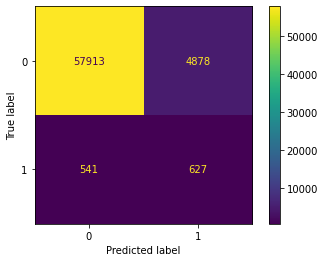

In [94]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_predict, y_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

Find best threshold by plotting RoC curve

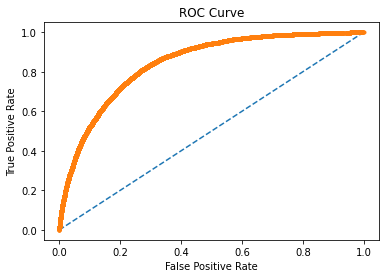

In [95]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

ns_probs = [0] * len(y_test)
lr_probs = log_reg.predict_proba(X_test)[:, 1]

ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)

ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)

plt.plot(ns_fpr, ns_tpr, linestyle='--')
plt.plot(lr_fpr, lr_tpr, marker='.',)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC Curve")
plt.show()

Adjust threshold

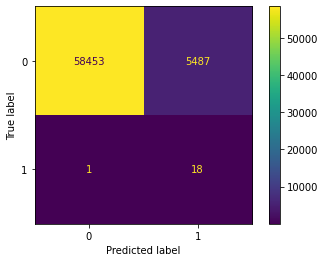

In [96]:
pred_proba_df = log_reg.predict_proba(X_test)[:, 1]
y_predict = np.array([1 if x > 0.844 else 0 for x in pred_proba_df])

cm = confusion_matrix(y_predict, y_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

Logistic Regression with Class Reweighted

In [97]:
log_reg = LogisticRegression(class_weight="balanced")

#fit the model to the training data set
log_reg.fit( X_train, y_train)

#calculated the accuracy (i.e. predicted vs. actual for the training data set)
acc = log_reg.score(X_train, y_train)
print('Accuracy: {:.2f}%'.format(acc*100))

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 75.08%


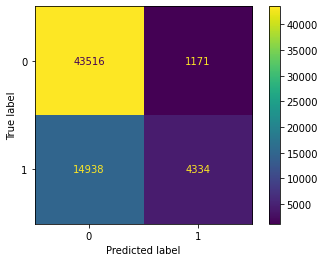

In [98]:
y_predict = log_reg.predict(X_test)

cm = confusion_matrix(y_predict, y_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

Oversample to adjust dataset for label unbalanced problem

In [99]:
from imblearn.over_sampling import RandomOverSampler
oversample = RandomOverSampler(sampling_strategy='minority')
X_over, y_over = oversample.fit_resample(X_train, y_train)

Create a Baseline Prediction

In [100]:
baseline_prediction = yscaler.inverse_transform( y_test.mean().reshape(-1,1)) 

#populate an array with the baseline prediction value
predictions = np.full(shape=y_test.shape[0], fill_value = baseline_prediction)

#unscale predicted values
actual= yscaler.inverse_transform( y_test )

#calculate the root mean square error between the prediction and the actual
naive = mean_squared_error(predictions, actual, squared=False)
print( 'Naive ERROR: {:,.5f}'.format(naive) )

Naive ERROR: 0.28047


Build the Neural Network, Compile & Train

In [101]:
def plot_learning_curve( history ):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    ymin, ymax = [], []
    for x in history.history.keys():
        ymax.append( max(history.history[x]))
        ymin.append( min(history.history[x]))
    plt.gca().set_ylim(min(ymin)*.95, max(ymax)*1.05)
    plt.xlabel("EPOCHS")
    plt.show()

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

#resets the Keras global state - helps avoid clutter from old models and layers, especially when memory is limited
keras.backend.clear_session()

In [ ]:
early_stopping = keras.callbacks.EarlyStopping(
patience = 2,
mode='min',
monitor='val_loss'
)

In [ ]:
model = keras.models.Sequential([
    keras.layers.Flatten(),
    keras.layers.Dense(4, activation="relu"),
    keras.layers.Dropout(.2),
    keras.layers.Dense(2, activation="relu"),
    keras.layers.Dense(1)
])

In [ ]:
model.compile(loss="mean_squared_error",
              optimizer=keras.optimizers.SGD(learning_rate=.0001),
             )

In [ ]:
history = model.fit(X_train, 
                    y_train, 
                    epochs=150, 
                    validation_split=.2,
                    callbacks=[early_stopping]
                   )

Epoch 1/150
6396/6396 [==============================] - 19s 3ms/step - loss: 0.1633 - val_loss: 0.0831
Epoch 2/150
6396/6396 [==============================] - 17s 3ms/step - loss: 0.0856 - val_loss: 0.0740
Epoch 3/150
6396/6396 [==============================] - 18s 3ms/step - loss: 0.0781 - val_loss: 0.0708
Epoch 4/150
6396/6396 [==============================] - 17s 3ms/step - loss: 0.0754 - val_loss: 0.0696
Epoch 5/150
6396/6396 [==============================] - 17s 3ms/step - loss: 0.0740 - val_loss: 0.0689
Epoch 6/150
6396/6396 [==============================] - 16s 3ms/step - loss: 0.0732 - val_loss: 0.0687
Epoch 7/150
6396/6396 [==============================] - 18s 3ms/step - loss: 0.0727 - val_loss: 0.0684
Epoch 8/150
6396/6396 [==============================] - 17s 3ms/step - loss: 0.0723 - val_loss: 0.0681
Epoch 9/150
6396/6396 [==============================] - 17s 3ms/step - loss: 0.0720 - val_loss: 0.0680
Epoch 10/150
6396/6396 [==============================] - 18s 3m

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 22)                0         
                                                                 
 dense (Dense)               (None, 4)                 92        
                                                                 
 dropout (Dropout)           (None, 4)                 0         
                                                                 
 dense_1 (Dense)             (None, 2)                 10        
                                                                 
 dense_2 (Dense)             (None, 1)                 3         
                                                                 
Total params: 105
Trainable params: 105
Non-trainable params: 0
_________________________________________________________________


Evaluate Performance

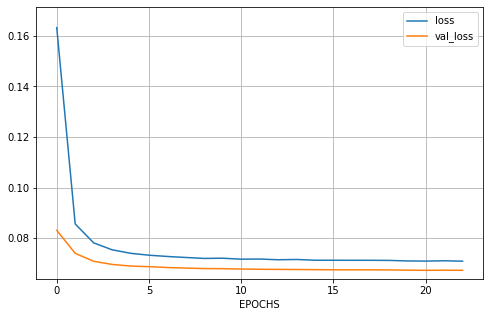

In [ ]:
nn_plot_learning_curve(history)

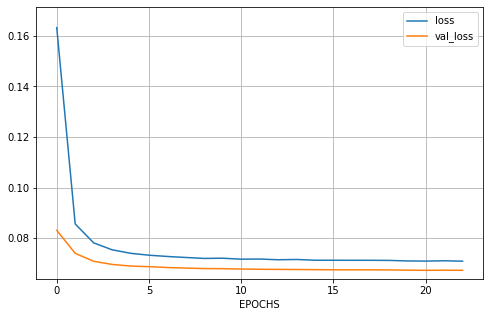

In [ ]:
plot_learning_curve(history)

In [ ]:
model.evaluate(X_train, y_train)

7995/7995 [==============================] - 14s 2ms/step - loss: 0.0688


0.06876396387815475

In [ ]:
model.evaluate(X_test, y_test)

1999/1999 [==============================] - 3s 2ms/step - loss: 0.0688


0.06883466243743896

In [ ]:
y_pred = model.predict(X_train)

#scale predicted and actuals
pred = yscaler.inverse_transform( y_pred )
actual = yscaler.inverse_transform(y_train)

#calculate the Root Mean Squared Error using the scaled values
rmse = mean_squared_error(pred,actual,squared=False)
print('RMSE: {:,.4f}'.format( rmse ) )

7995/7995 [==============================] - 10s 1ms/step
RMSE: 0.2622


In [ ]:
y_pred = model.predict(X_test)

#scale predicted and actuals
pred = yscaler.inverse_transform( y_pred )
actual = yscaler.inverse_transform(y_test)

#calculate the Root Mean Squared Error using the scaled values
rmse = mean_squared_error(pred,actual,squared=False)
print('RMSE: {:,.4f}'.format( rmse ) )

1999/1999 [==============================] - 3s 1ms/step
RMSE: 0.2624


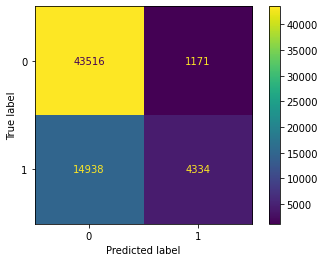

In [ ]:
nn_cm = confusion_matrix(y_predict, y_test)
disp = ConfusionMatrixDisplay(confusion_matrix=nn_cm)
disp.plot()
plt.show()

In [ ]:
pred[0:5], actual[0:5]

(array([[0.06129381],
        [0.03976327],
        [0.03976327],
        [0.03976327],
        [0.22223392]], dtype=float32), array([[0.],
        [1.],
        [0.],
        [0.],
        [0.]]))

In [ ]:
for x in range(0,20):
    print( "Prediction {:10,.0f}  ---  Actual {:10,.0f}".format( float(pred[x:x+1]), float(actual[x:x+1]) ) )

Prediction          0  ---  Actual          0
Prediction          0  ---  Actual          1
Prediction          0  ---  Actual          0
Prediction          0  ---  Actual          0
Prediction          0  ---  Actual          0
Prediction          0  ---  Actual          0
Prediction          0  ---  Actual          0
Prediction          0  ---  Actual          0
Prediction          0  ---  Actual          0
Prediction          0  ---  Actual          0
Prediction          0  ---  Actual          0
Prediction          0  ---  Actual          0
Prediction          0  ---  Actual          0
Prediction          0  ---  Actual          0
Prediction          0  ---  Actual          0
Prediction          0  ---  Actual          0
Prediction          0  ---  Actual          0
Prediction          0  ---  Actual          0
Prediction          0  ---  Actual          0
Prediction          0  ---  Actual          0


Random Forest

Accuracy: 90.41%


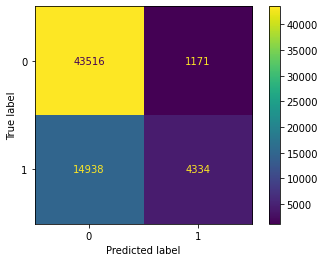

In [102]:
model_RandomForest = RandomForestClassifier(criterion='entropy',n_estimators=50)
model_RandomForest.fit(X_train,y_train.reshape(-1))
y_predict_RF = model_RandomForest.predict(X_test)

score = accuracy_score(y_test,y_predict_RF)
print('Accuracy: {:.2f}%'.format(score*100))

confusion_matrix_RF = confusion_matrix(y_test,y_predict_RF)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

Random Forest Feature Importance

22
[ 0.15657847  0.          0.          1.          0.16666667  0.
  1.          1.          0.          0.          0.30434783  0.
  0.          1.          0.          0.          0.          0.
  0.          1.         12.          2.        ]


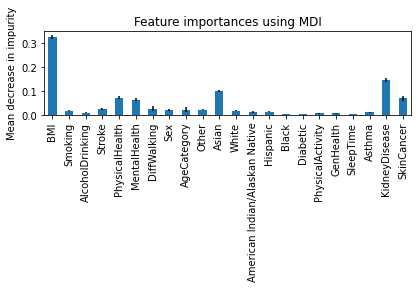

In [111]:
print(X_train.shape[1])
print(X_train[0])
feature_importance = model_RandomForest.feature_importances_
# print(feature_importance)
forest_importances = pd.Series(feature_importance)
# print(forest_importances)
std = np.std([tree.feature_importances_ for tree in model_RandomForest.estimators_], axis=0)
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
x = ["BMI", "Smoking", "AlcoholDrinking", "Stroke", "PhysicalHealth", "MentalHealth", "DiffWalking", "Sex", "AgeCategory", "Other", "Asian", "White", "American Indian/Alaskan Native", "Hispanic", "Black", "Diabetic", "PhysicalActivity", "GenHealth", "SleepTime", "Asthma", "KidneyDisease", "SkinCancer"]
plt.xticks((0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21), x)
# for i in range(len(x)):
#   plt.text(i,x[i],std[i])
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()